In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("husl")
sns.set_style("whitegrid")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
#dataset = "initial"
dataset = "incremental"
reference_algorithm = "Boost Kruskal"

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [3]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]
reference_times = df[(df.Algorithm == reference_algorithm) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']
df['Reference speedup'] = df.apply(lambda x: reference_times[x.Graph] / x.time if x.Graph in reference_times.index else None , 1)
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

In [4]:
s = df[["Algorithm", "Graph", "Max threads", "speedup", "time"]]\
    .groupby(("Graph", "Algorithm", "Max threads"))\
    .agg(["median", "std"])
s.time.to_csv(f"summaries/{dataset}/time_summary.csv")
s.time.to_latex(f"summaries/{dataset}/time_summary.tex")
s.speedup.to_csv(f"summaries/{dataset}/speedup_summary.csv")
s.speedup.to_latex(f"summaries/{dataset}/speedup_summary.tex")

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [5]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Reference speedup,speedup
id,,,,,,,,,,,
0,Boost Kruskal,100000,Preferential attachment 50 edges per vertice,1,0,6.560871e+06,0,"(Preferential attachment 50 edges per vertice,...",1.524188e-07,0.966072,0.966072
0,Boost Kruskal,100000,Preferential attachment 50 edges per vertice,1,1,6.115681e+06,0,"(Preferential attachment 50 edges per vertice,...",1.635141e-07,1.036397,1.036397
0,Boost Kruskal,100000,Preferential attachment 50 edges per vertice,2,0,5.821162e+06,1,"(Preferential attachment 50 edges per vertice,...",1.717870e-07,1.088834,1.088834
0,Boost Kruskal,100000,Preferential attachment 50 edges per vertice,2,1,6.063366e+06,0,"(Preferential attachment 50 edges per vertice,...",1.649249e-07,1.045340,1.045340
0,Boost Kruskal,100000,Preferential attachment 50 edges per vertice,4,0,5.875454e+06,0,"(Preferential attachment 50 edges per vertice,...",1.701996e-07,1.078772,1.078772


In [6]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Reference speedup,speedup
id,,,,,,,,,,,
0,Filter Sollin,10000,Erdos-Renyi random p=0.100000,8,1,4.045843e+06,1,"(Erdos-Renyi random p=0.100000, 10000)",2.471673e-07,1.469682,0.139855
0,Filter Sollin,10000,Erdos-Renyi random p=0.100000,16,0,3.482964e+05,3,"(Erdos-Renyi random p=0.100000, 10000)",2.871117e-06,17.071962,1.624569
0,Filter Sollin,10000,Erdos-Renyi random p=0.100000,16,1,3.101290e+06,0,"(Erdos-Renyi random p=0.100000, 10000)",3.224465e-07,1.917300,0.182450
0,Filter Sollin,10000,Erdos-Renyi random p=0.100000,32,0,3.922012e+06,0,"(Erdos-Renyi random p=0.100000, 10000)",2.549712e-07,1.516085,0.144271
0,Filter Sollin,10000,Erdos-Renyi random p=0.100000,32,1,2.619529e+05,0,"(Erdos-Renyi random p=0.100000, 10000)",3.817481e-06,22.699136,2.160051


In [7]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [8]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [9]:
summary

time                \
                                                   median          mean   
Algorithm           Max threads Graph nodes                               
Boost Kruskal       1           10000        9.301274e+06  9.301274e+06   
                                100000       4.421094e+06  4.421094e+06   
                    2           10000        9.368125e+06  9.368125e+06   
                                100000       4.320274e+06  4.320274e+06   
                    4           10000        9.238074e+06  9.238074e+06   
                                100000       4.256771e+06  4.256771e+06   
                    8           10000        9.217528e+06  9.217528e+06   
                                100000       4.307274e+06  4.307274e+06   
                    16          10000        9.304455e+06  9.304455e+06   
                                100000       4.316865e+06  4.316865e+06   
                    32          10000        9.283184e+06  9.283184e+06   
                                100000       4.321296e+06  4.321296e+06   
Boost Prim          1           10000        7.484774e+06  7.484774e+06   
                                100000       2.999925e+06  2.999925e+06   
                    2           10000        7.485407e+06  7.485407e+06   
                                100000       2.867324e+06  2.867324e+06   
                    4           10000        7.430611e+06  7.430611e+06   
                                100000       2.830127e+06  2.830127e+06   
                    8           10000        7.755227e+06  7.755227e+06   
                                100000       2.870468e+06  2.870468e+06   
                    16          10000        7.566153e+06  7.566153e+06   
                                100000       2.832843e+06  2.832843e+06   
                    32          10000        7.575140e+06  7.575140e+06   
                                100000       2.846529e+06  2.846529e+06   
Filter Kruskal      1           10000        8.461437e+05  8.743528e+05   
                                100000       4.236412e+05  4.590769e+05   
                    2           10000        4.941844e+05  5.373134e+05   
                                100000       2.524743e+05  2.532177e+05   
                    4           10000        3.481330e+05  3.400810e+05   
                                100000       1.623589e+05  1.632184e+05   
...                                                   ...           ...   
Filter Sollin       8           10000        4.146749e+06  4.149656e+06   
                                100000       6.223893e+06  5.698124e+06   
                    16          10000        4.872778e+06  5.699969e+06   
                                100000       4.500488e+06  4.003606e+06   
                    32          10000        3.415534e+06  3.110134e+06   
                                100000       4.827957e+06  4.394219e+06   
Sequential Kruskal  1           10000        3.446359e+06  3.446359e+06   
                                100000       1.746570e+06  1.746570e+06   
                    2           10000        3.116342e+06  3.116342e+06   
                                100000       1.558119e+06  1.558119e+06   
                    4           10000        2.684062e+06  2.684062e+06   
                                100000       1.375521e+06  1.375521e+06   
                    8           10000        2.799780e+06  2.799780e+06   
                                100000       1.407220e+06  1.407220e+06   
                    16          10000        3.230686e+06  3.230686e+06   
                                100000       1.503423e+06  1.503423e+06   
                    32          10000        2.725289e+06  2.725289e+06   
                                100000       1.381545e+06  1.381545e+06   
parallel sollin FAL 1           10000        2.808290e+06  3.617965e+06   
                                100000       2.097005e+06  2.415897e+06   
   

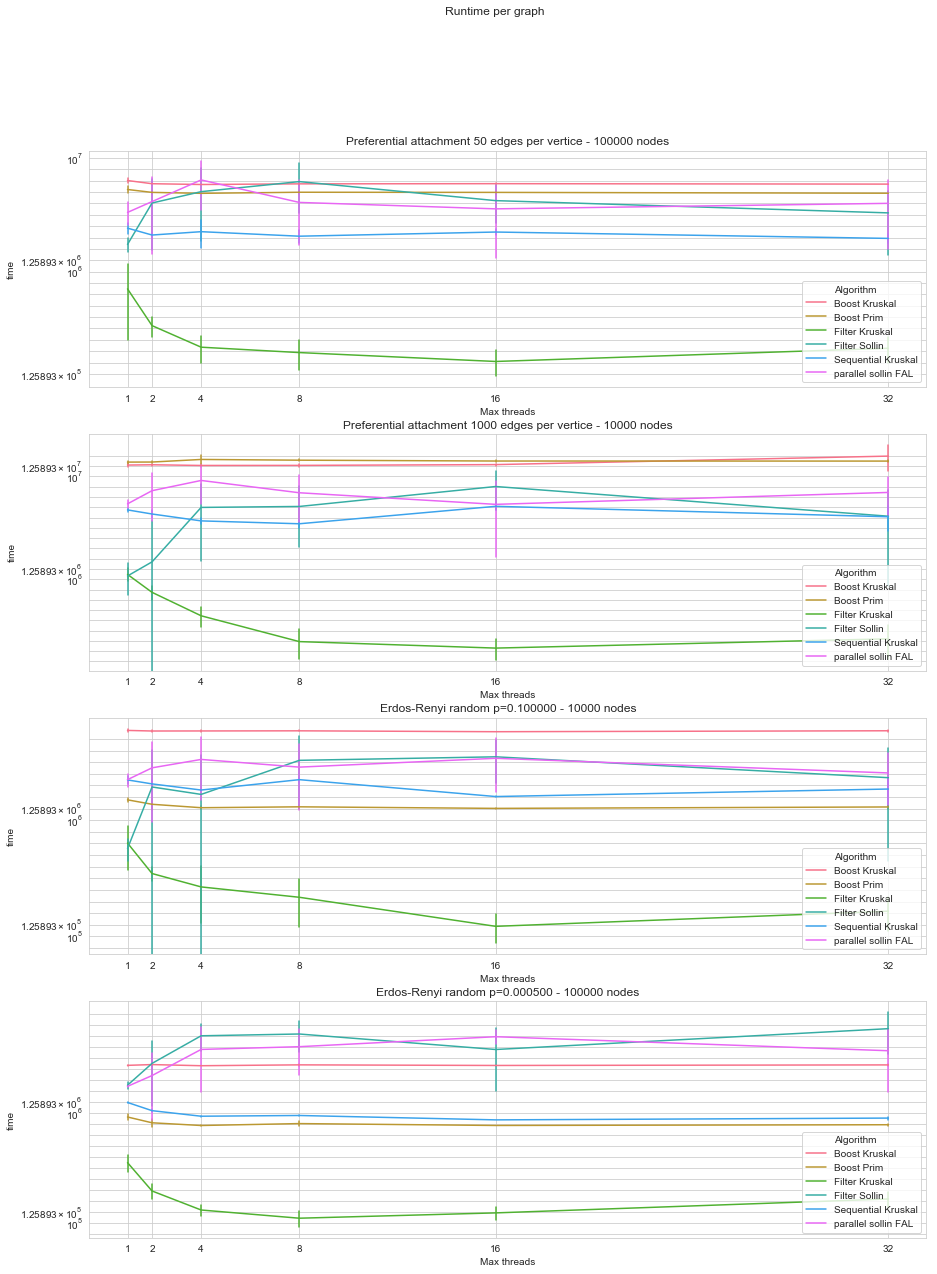

In [10]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/Graph_runtime.png", dpi=450)
plt.show()

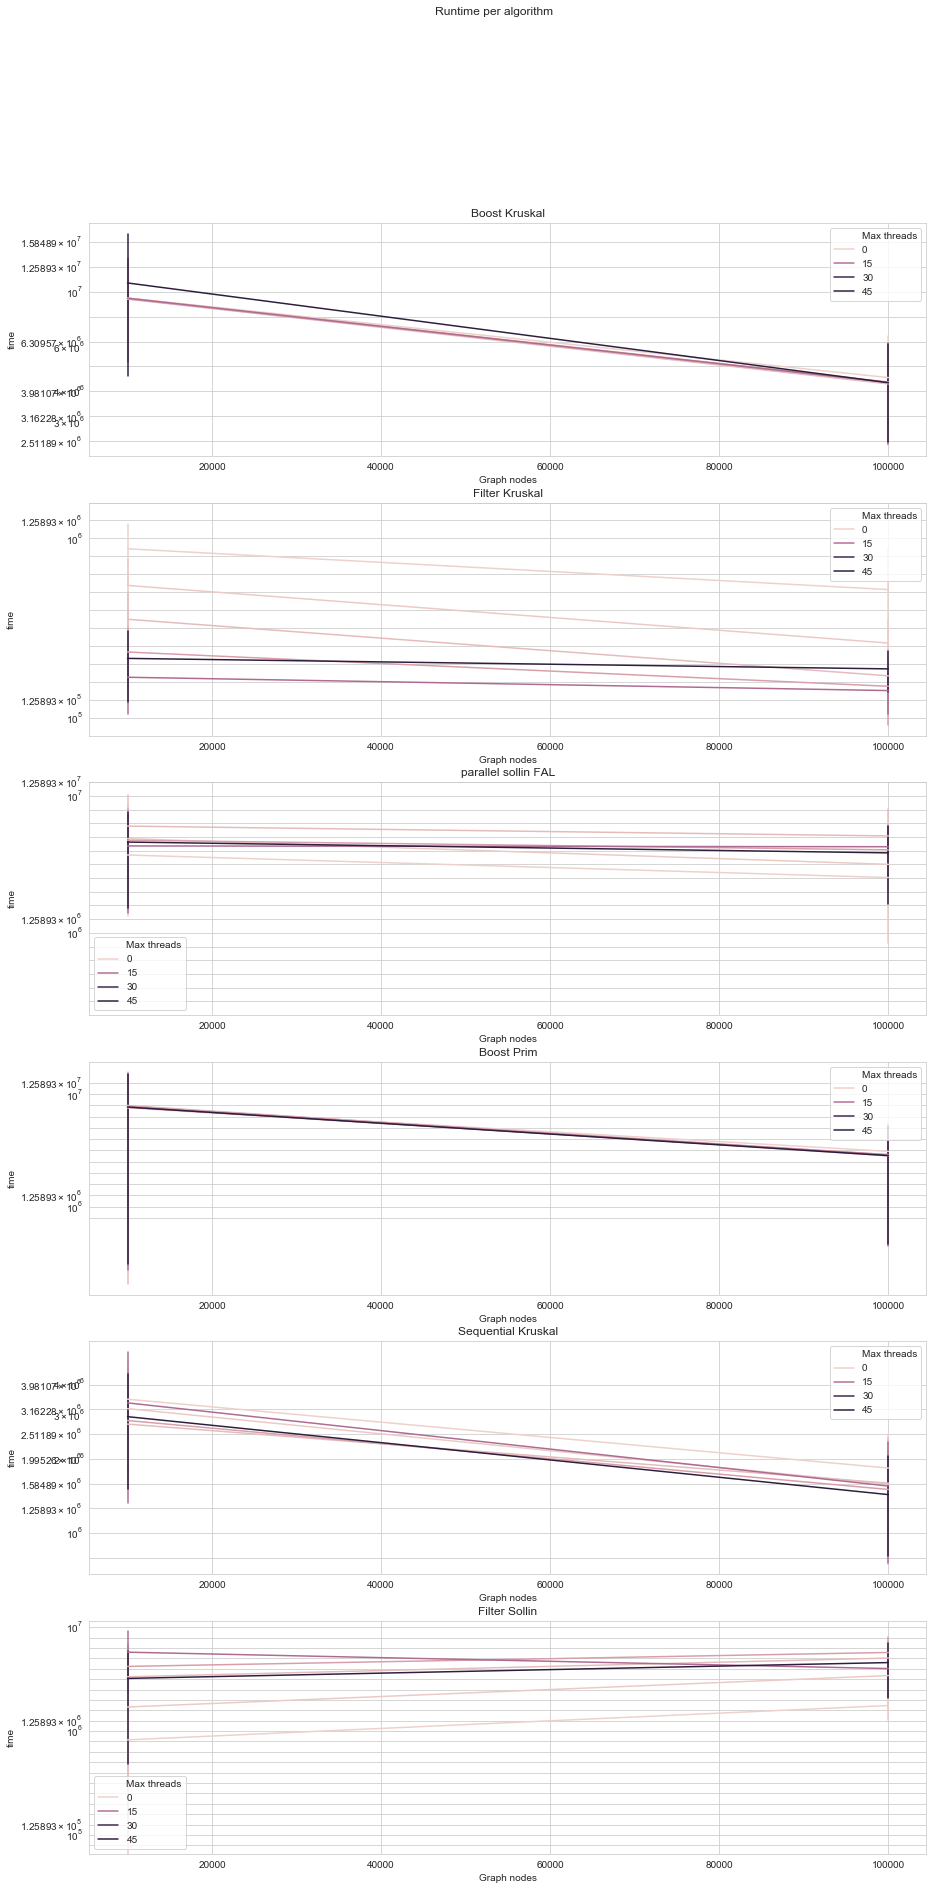

In [11]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi,
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df["Algorithm"].values == e]["time"]), np.max(df[df["Algorithm"].values == e]["time"])])
    axi.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    axi.set_title(f"{e}")
plt.suptitle("Runtime per algorithm")
fig.savefig(f"figures/{dataset}/AlgoRuntime.png", dpi=450)
plt.show()

In [12]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


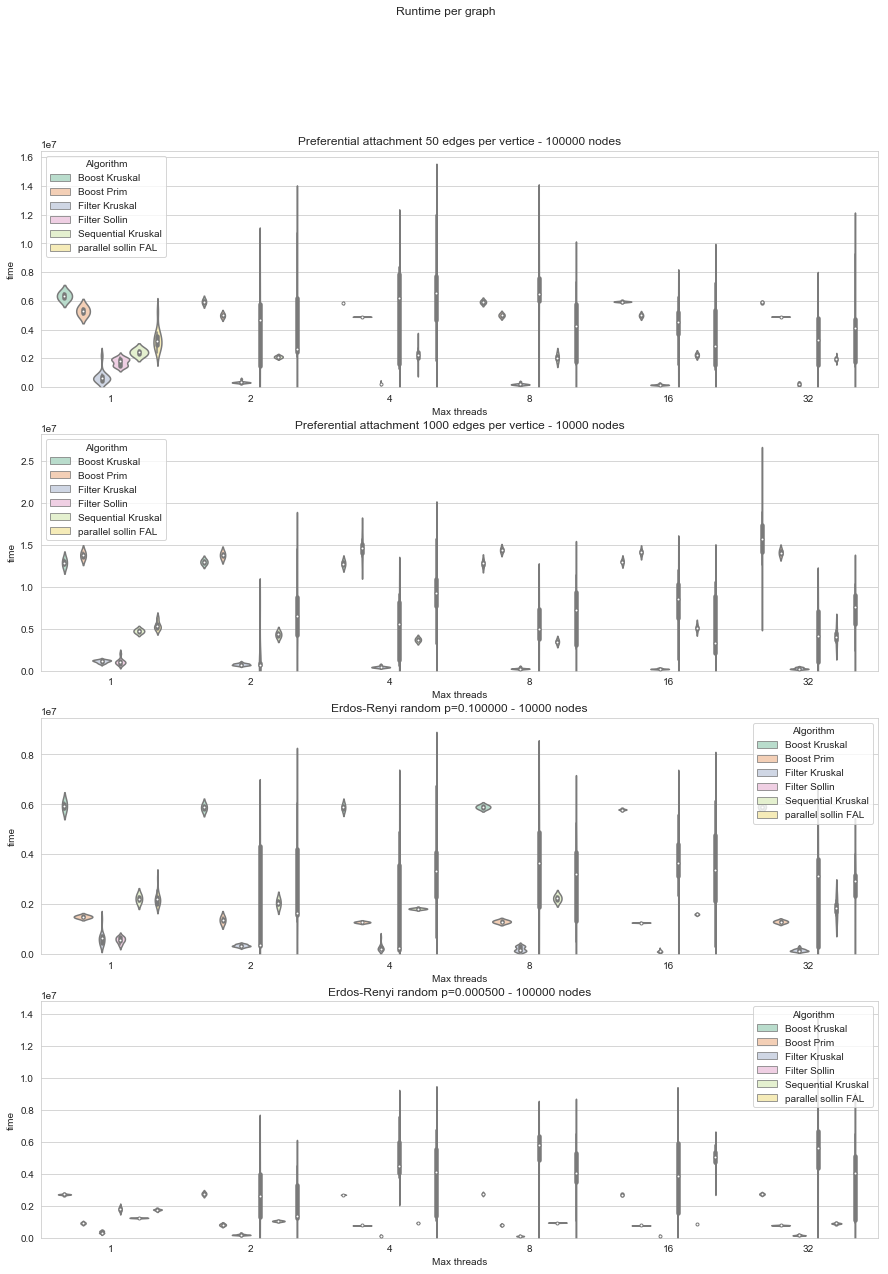

In [13]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/ViolinRuntime.png", dpi=450)
plt.show()

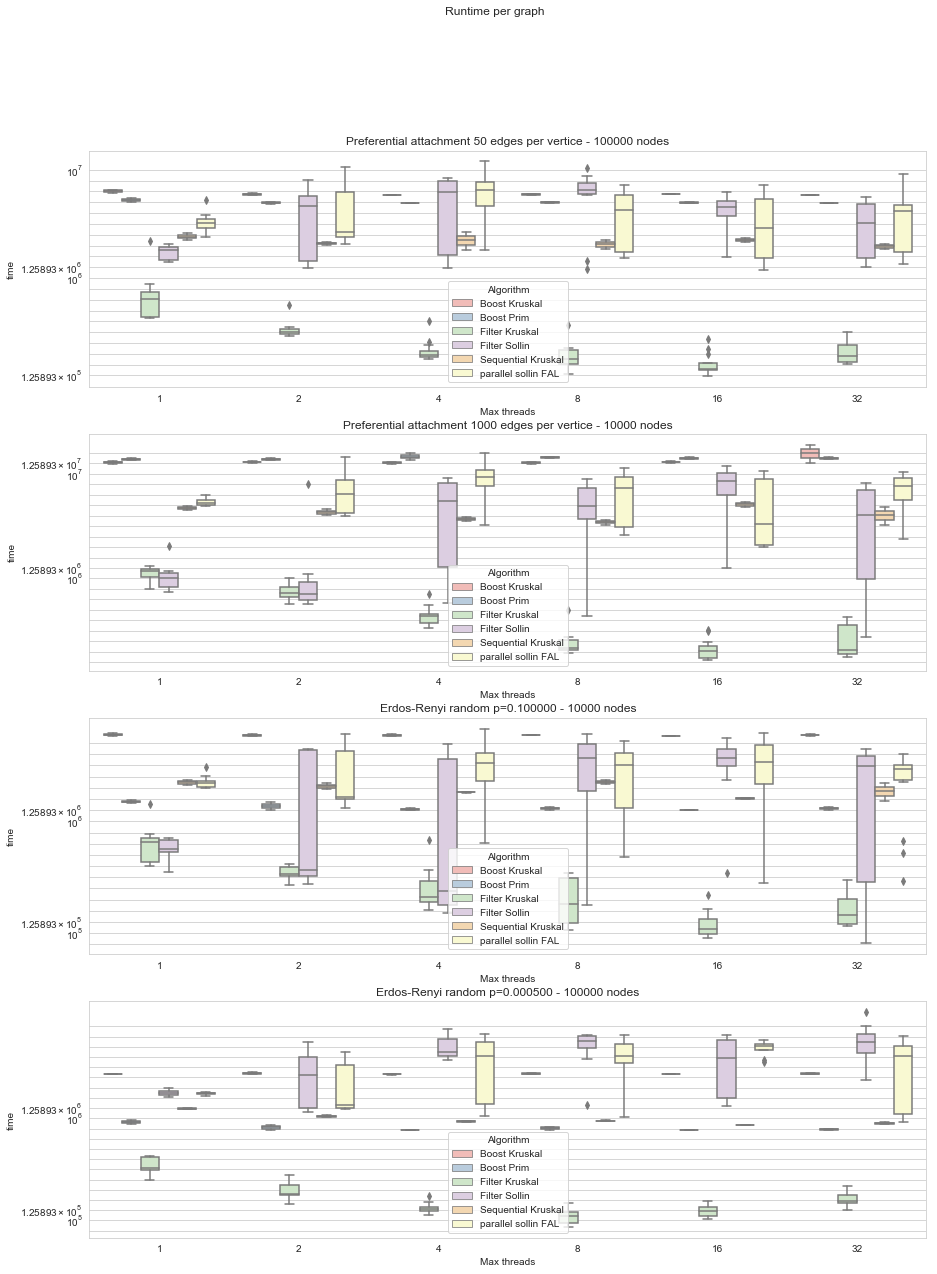

In [14]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/BoxRuntime.png", dpi=450)
plt.show()

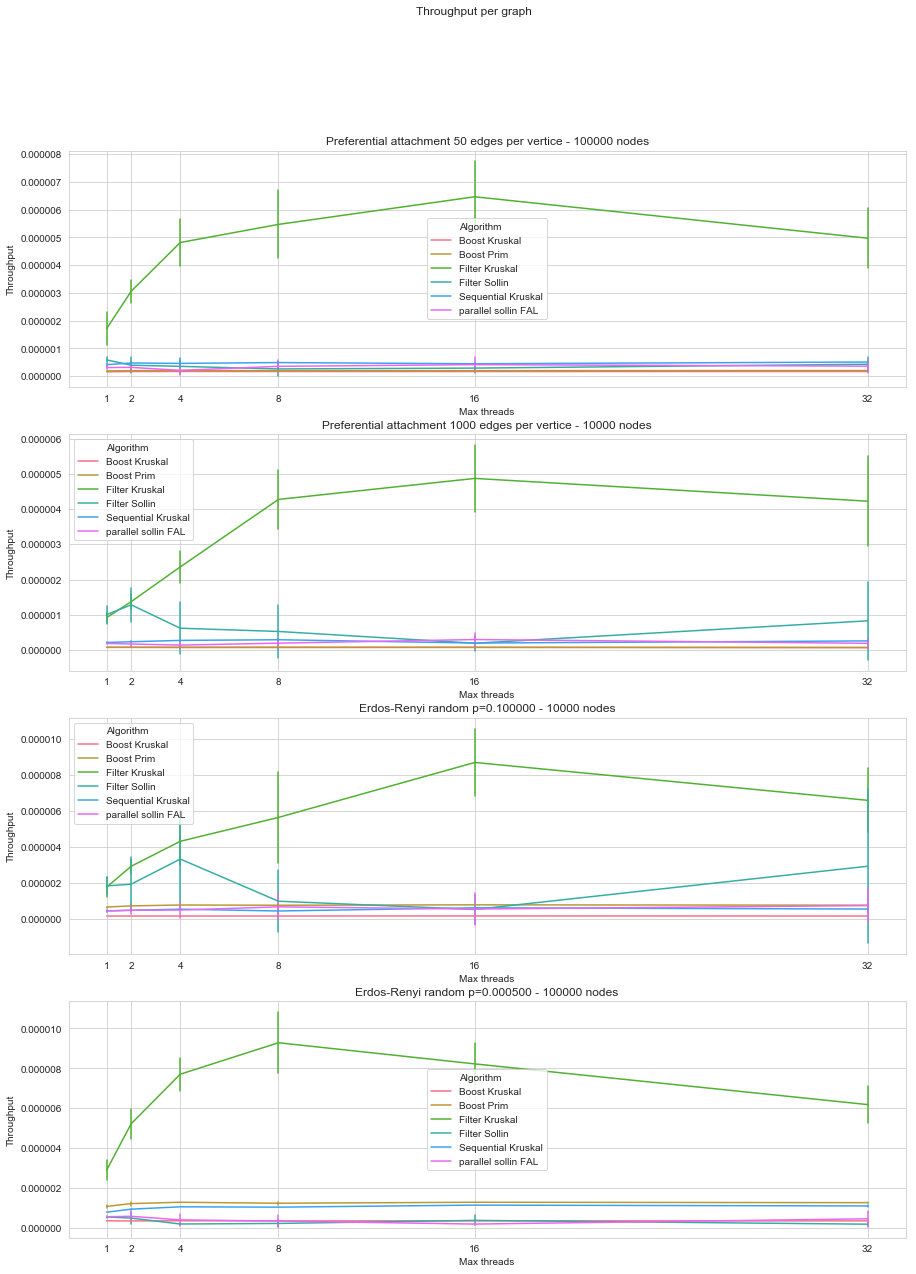

In [15]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Throughput per graph")
fig.savefig(f"figures/{dataset}/Throughput.png", dpi=450)
plt.show()

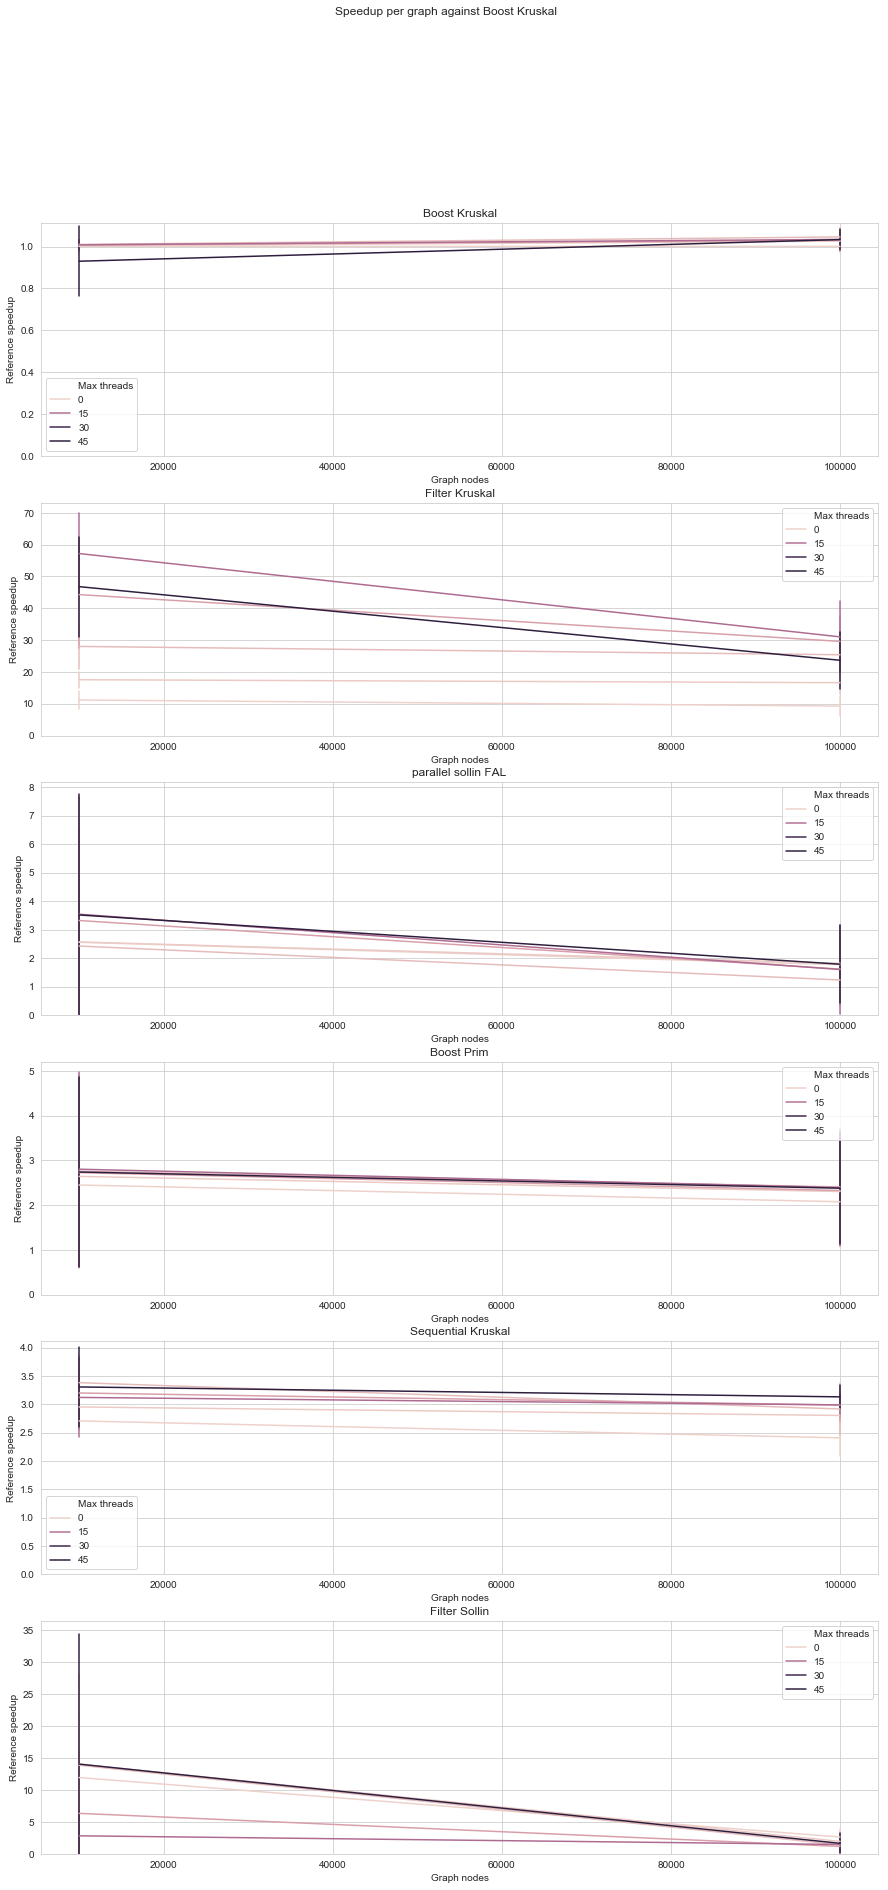

In [16]:
fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi, 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="Reference speedup", 
        hue="Max threads",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(0,)
plt.suptitle(f"Speedup per graph against {reference_algorithm}")
r_name = reference_algorithm.replace(' ', '_')
fig.savefig(f"figures/{dataset}/Speedup_against_{r_name}.png", dpi=450)
plt.show()

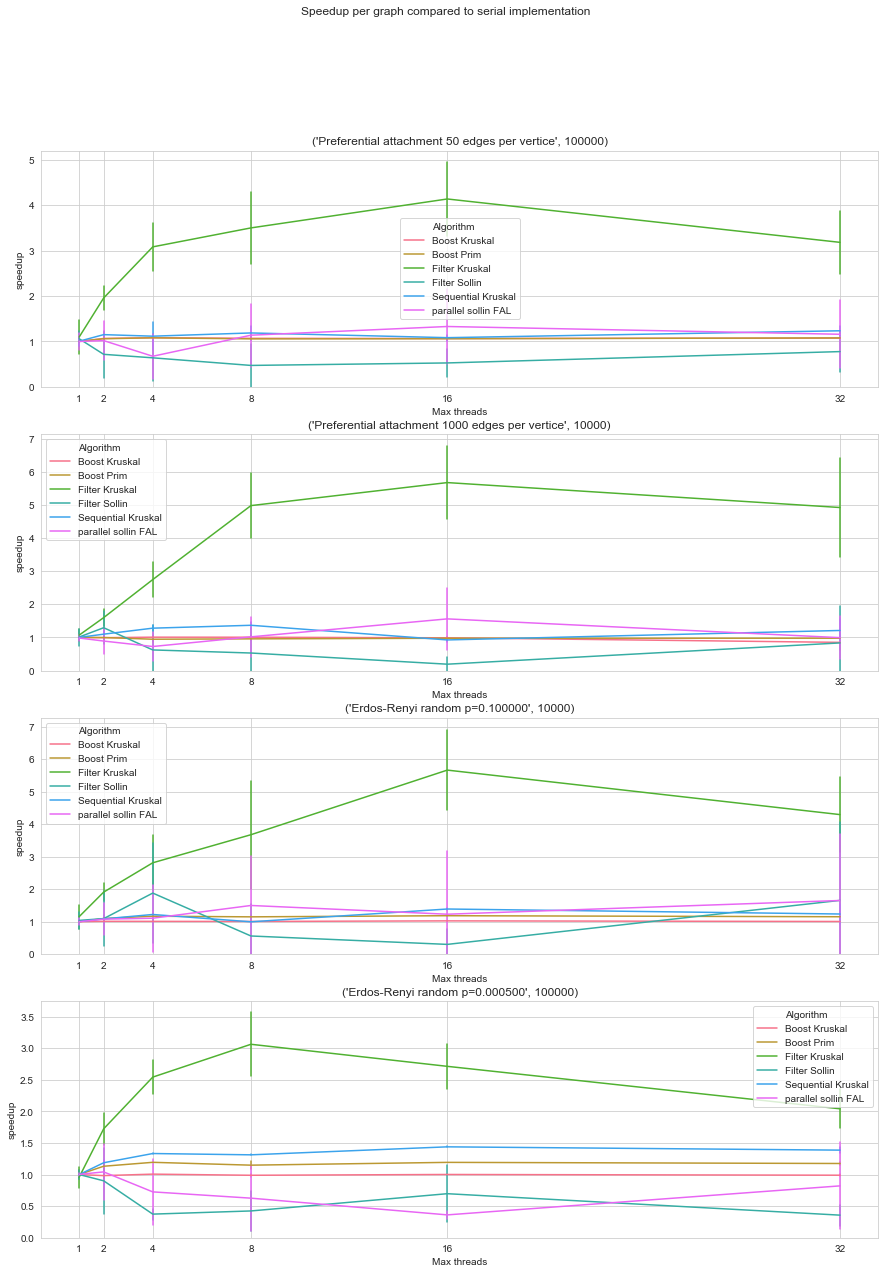

In [17]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_xticks(2**np.arange(0, 6, 1))
    ax[i].set_title(f"{e}")
    ax[i].set_ylim(0,)
plt.suptitle(f"Speedup per graph compared to serial implementation")
fig.savefig(f"figures/{dataset}/Speedup.png", dpi=450)
plt.show()